# Partie II - Motion Compensation

### Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Load and display images

In [2]:
def load_image(path: str) -> np.ndarray:
    """
    Load image from path and convert it to grayscale
    
    :param path: path to image
    :return: image in grayscale
    """
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def display_images(imgs: np.ndarray) -> None:
    """
    Display two images with matplotlib

    :param img1: first image to display
    :param img2: second image to display
    :param title1: title of the first image
    :param title2: title of the second image
    """
    num_imgs = imgs.shape[0]
    _, axs = plt.subplots(1, num_imgs, figsize=(8, 4))
    for i in range(num_imgs):
        axs[i].imshow(imgs[i], cmap='gray')
        axs[i].set_title(f'Frame {i}')
        axs[i].axis('off')
    plt.show()

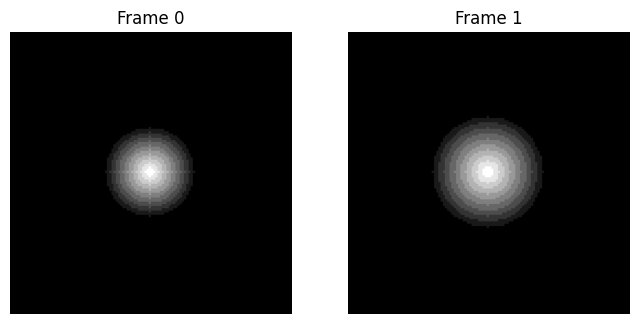

In [3]:
pic1, pic2 = load_image('./images/1.png'), load_image('./images/2.png')
display_images(np.array([pic1, pic2]))

### A - Backward estimation
Au TP1, vous avez r ́ealis ́e de l’estimation de mouvement de type forward par blocs entre F1 et F2. Procédez maintenant à de l’estimation backward par blocs entre F1 et F2.</br>
<u>Note :</u> c’est d ́esormais F2 que l’on d ́ecompose en blocs et non pas F1.

### B - Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ? Que se serait-il passé sinon ? (pensez à quels artéfacts visuels on aurait obtenu)


### C - Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de F1. Quelle est la MSE de reconstruction ?

### D - Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données ”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la reconstruire de façon parfaite en compensation de mouvement ?

### E - Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE de reconstruction ?

### F - Expliquez quelles données on peut coder avec perte pour garder une qualité de reconstruction de F1 et F2 ”correcte”. Justifiez vos explications par des images de rendus.

### G - Qu’est-ce-qui aurait changé si on utilise une méthode à base de mesh du point de vue de la minimisation ? Et du point de vue du rendu final ? Montrez vos résultats en vous aidant du TP1.